# Brain Tumor MRI Dataset Exploration


Bu notebook, Kaggle'dan alınan Beyin Tümörü MRI Veri Setini incelemektedir. Bu veri seti, beyinlerin MRI taramalarını dört sınıfa ayırmaktadır: Glioma, Meningioma, No tumor ve Pituitary.


## Gerekli Kütüphaneleri İçe Aktarma


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import random
from pathlib import Path
from tqdm.notebook import tqdm



Grafik stilini ayarlama


In [2]:
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')



Grafik boyutlarını artırma


In [3]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14



## Veri Setini Yükleme ve Keşfetme


Öncelikle, veri setinin yapısını kontrol edelim ve her sınıftaki görüntü sayısını sayalım.


Veri seti yolunu tanımlama


In [4]:
data_dir = Path('/Users/onurakyuz/Desktop/Brain Tumor MRI/data')



Veri setinin var olup olmadığını kontrol etme


In [5]:
if not data_dir.exists():
    print("Veri seti bulunamadı. Lütfen Kaggle'dan indirip data dizinine yerleştirin.")
else:
    print("Veri seti bulundu!")
    
    # Veri setindeki tüm dizinleri listeleme
    for split in ['Training', 'Testing']:
        split_dir = data_dir / split
        print(f"\n{split} seti:")
        
        class_counts = {}
        for class_dir in split_dir.iterdir():
            if class_dir.is_dir():
                class_name = class_dir.name
                num_images = len(list(class_dir.glob('*.jpg')))
                class_counts[class_name] = num_images
                print(f"  - {class_name}: {num_images} görüntü")
        
        print(f"  Toplam: {sum(class_counts.values())} görüntü")



Veri seti bulundu!

Training seti:
  - pituitary: 1457 görüntü
  - notumor: 1595 görüntü
  - glioma: 1321 görüntü
  - meningioma: 1339 görüntü
  Toplam: 5712 görüntü

Testing seti:
  - pituitary: 300 görüntü
  - notumor: 405 görüntü
  - glioma: 300 görüntü
  - meningioma: 306 görüntü
  Toplam: 1311 görüntü


## Sınıf Dağılımını Görselleştirme


Eğitim ve test setleri için sınıf dağılımını görselleştirme


In [6]:
def plot_class_distribution(data_dir):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    for i, split in enumerate(['Training', 'Testing']):
        split_dir = data_dir / split
        class_counts = {}
        
        for class_dir in split_dir.iterdir():
            if class_dir.is_dir():
                class_name = class_dir.name
                num_images = len(list(class_dir.glob('*.jpg')))
                class_counts[class_name] = num_images
        
        # Sınıf adlarını alfabetik sıraya göre sıralama
        sorted_classes = sorted(class_counts.keys())
        sorted_counts = [class_counts[cls] for cls in sorted_classes]
        
        # Çubuk grafiği oluşturma
        ax = axes[i]
        sns.barplot(x=sorted_classes, y=sorted_counts, ax=ax, palette='viridis')
        ax.set_title(f'{split} Seti Sınıf Dağılımı', fontsize=16)
        ax.set_xlabel('Sınıf', fontsize=14)
        ax.set_ylabel('Görüntü Sayısı', fontsize=14)
        
        # Çubukların üzerine sayı etiketleri ekleme
        for j, count in enumerate(sorted_counts):
            ax.text(j, count + 20, str(count), ha='center', fontsize=12)
            
        # X ekseni etiketlerini daha iyi okunabilirlik için döndürme
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()



Sınıf dağılımını görselleştirme fonksiyonunu çağırma


/var/folders/k5/tl7m5_711rzchhv0bd8ks9600000gn/T/ipykernel_14615/1990837651.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_classes, y=sorted_counts, ax=ax, palette='viridis')
/var/folders/k5/tl7m5_711rzchhv0bd8ks9600000gn/T/ipykernel_14615/1990837651.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/k5/tl7m5_711rzchhv0bd8ks9600000gn/T/ipykernel_14615/1990837651.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_classes, y=sorted_counts, ax=ax, palette='viridis')
/var/folders/k5/tl7m5_711rzchhv0bd8ks9600000gn/T/ip

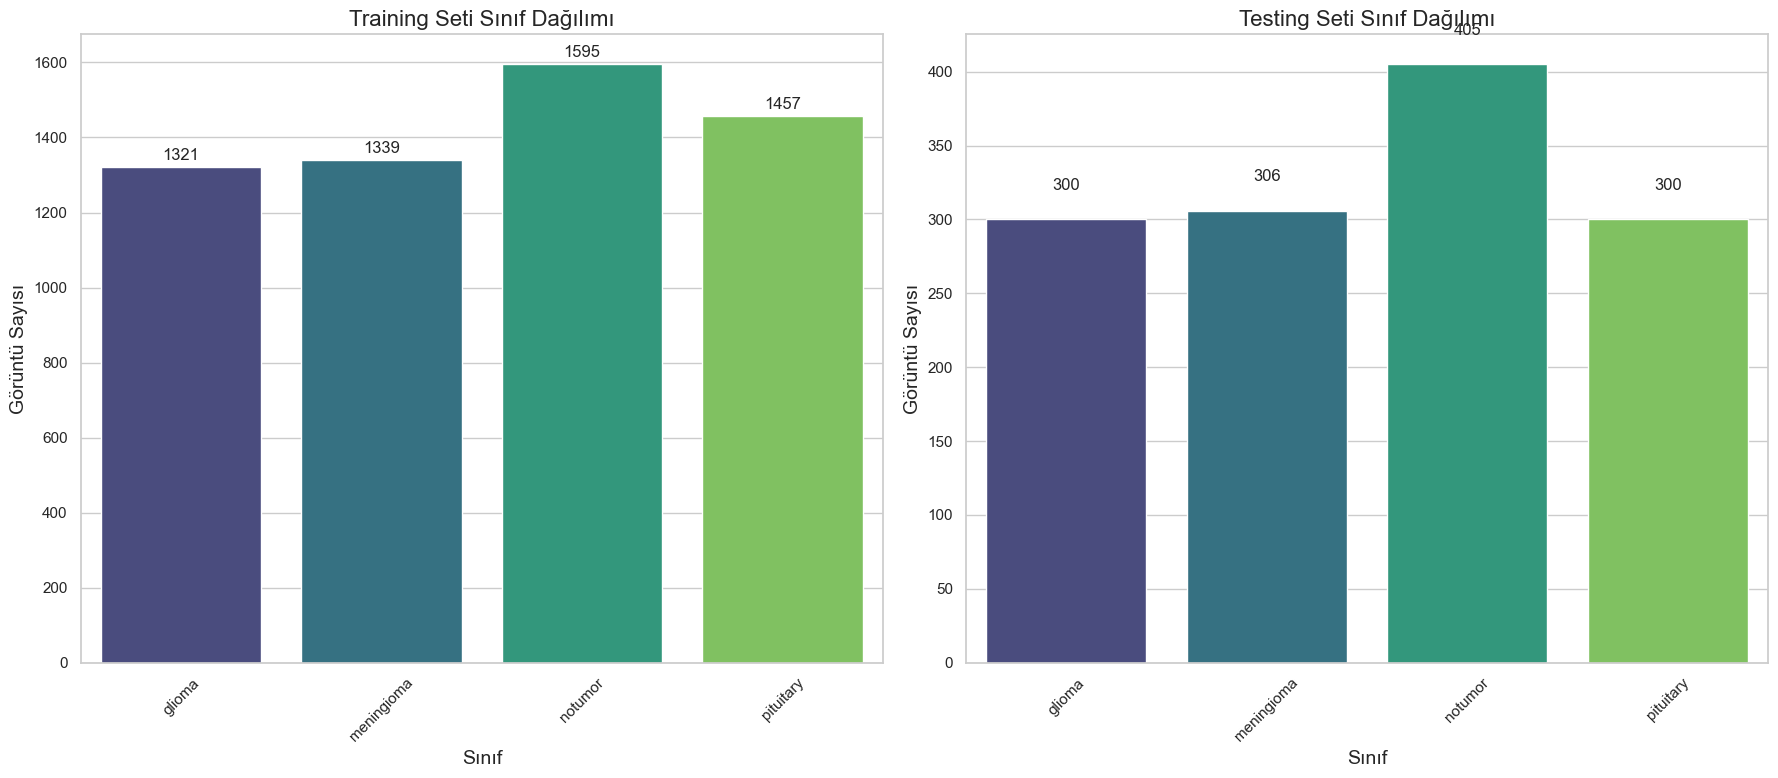

In [7]:
plot_class_distribution(data_dir)



## Her Sınıftan Örnek Görüntüleri Gösterme


In [8]:
def display_sample_images(data_dir, split='Training', num_samples=3):
    split_dir = data_dir / split
    class_dirs = sorted([d for d in split_dir.iterdir() if d.is_dir()])
    
    fig, axes = plt.subplots(len(class_dirs), num_samples, figsize=(15, 12))
    
    for i, class_dir in enumerate(class_dirs):
        class_name = class_dir.name
        image_paths = list(class_dir.glob('*.jpg'))
        
        # Rastgele görüntü seçme
        selected_images = random.sample(image_paths, min(num_samples, len(image_paths)))
        
        for j, img_path in enumerate(selected_images):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR'den RGB'ye dönüştürme
            
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'{class_name}')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'{split} Setinden Örnek Görüntüler', fontsize=16, y=1.02)
    plt.show()



Eğitim setinden örnek görüntüleri gösterme


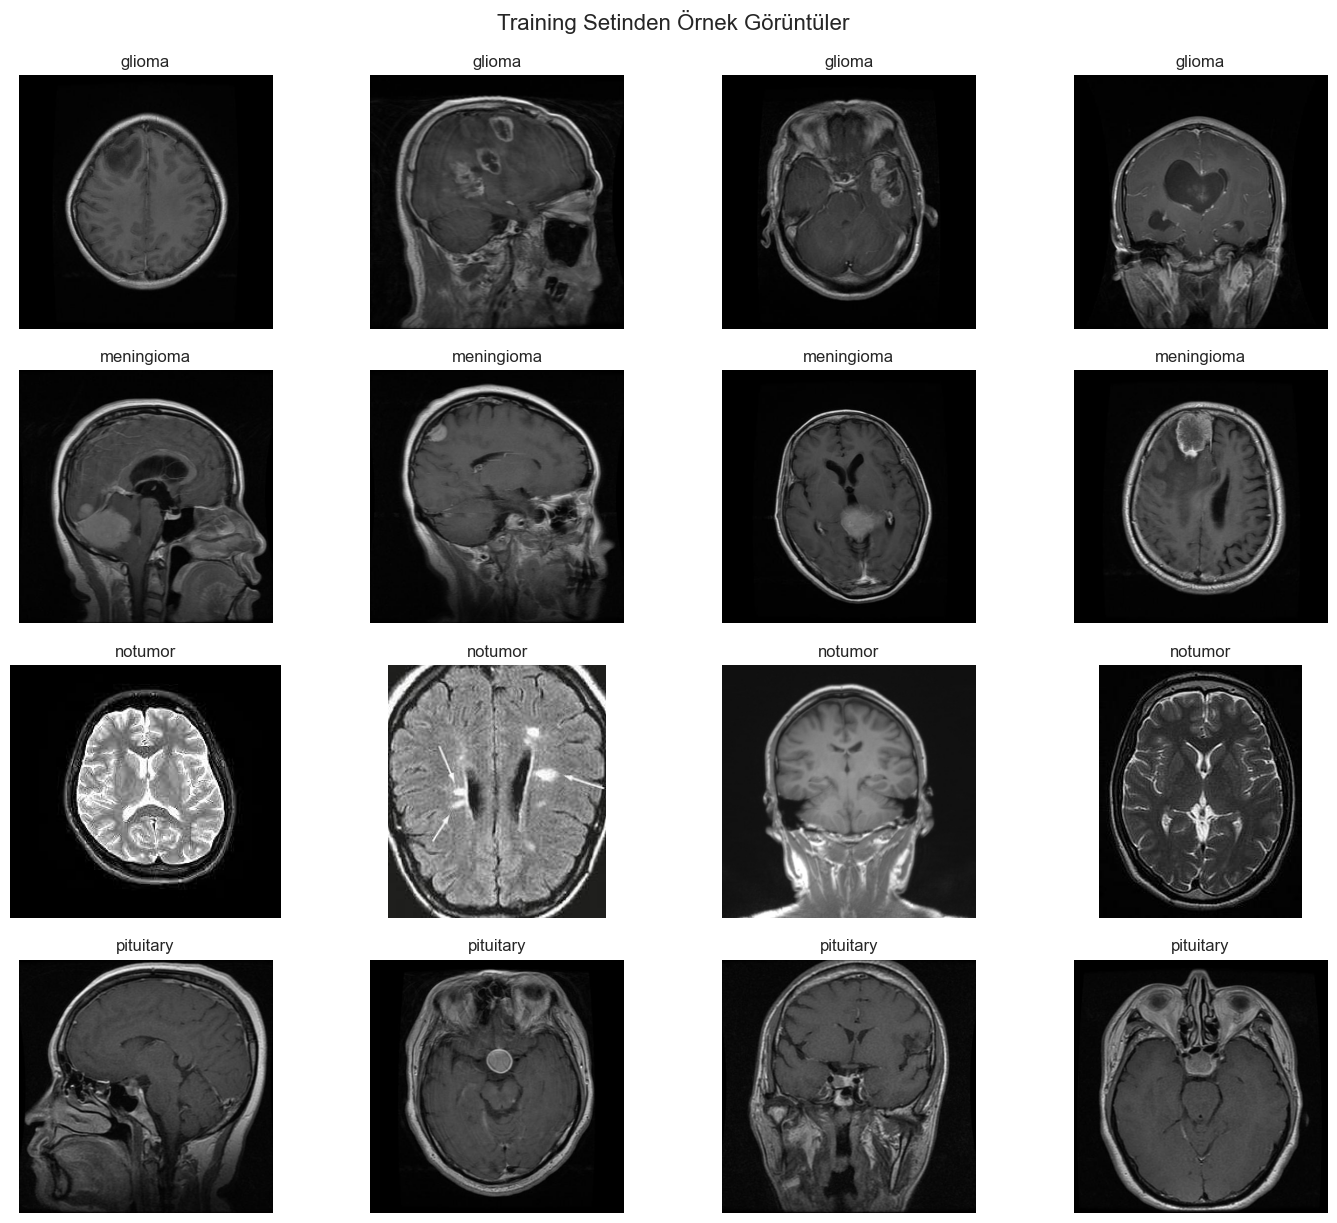

In [9]:
display_sample_images(data_dir, split='Training', num_samples=4)



## Görüntü Özelliklerini Analiz Etme


In [10]:
def analyze_image_properties(data_dir, split='Training', max_per_class=100):
    split_dir = data_dir / split
    
    # Görüntü özelliklerini saklamak için listeler
    widths = []
    heights = []
    aspect_ratios = []
    sizes = []  # KB cinsinden
    classes = []
    
    for class_dir in split_dir.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            img_paths = list(class_dir.glob('*.jpg'))
            
            # Görüntülerin bir alt kümesini örnekleme
            selected_paths = random.sample(img_paths, min(max_per_class, len(img_paths)))
            
            for img_path in tqdm(selected_paths, desc=f"{class_name} analiz ediliyor"):
                # KB cinsinden görüntü boyutunu alma
                size_kb = os.path.getsize(img_path) / 1024
                
                # Görüntüyü açma ve boyutlarını alma
                with Image.open(img_path) as img:
                    width, height = img.size
                    aspect_ratio = width / height
                
                # Listelere ekleme
                widths.append(width)
                heights.append(height)
                aspect_ratios.append(aspect_ratio)
                sizes.append(size_kb)
                classes.append(class_name)
    
    # DataFrame oluşturma
    df = pd.DataFrame({
        'Class': classes,
        'Width': widths,
        'Height': heights,
        'Aspect_Ratio': aspect_ratios,
        'Size_KB': sizes
    })
    
    return df



Eğitim görüntülerinin bir alt kümesini analiz etme


In [11]:
image_props_df = analyze_image_properties(data_dir, split='Training', max_per_class=50)



pituitary analiz ediliyor:   0%|          | 0/50 [00:00<?, ?it/s]

notumor analiz ediliyor:   0%|          | 0/50 [00:00<?, ?it/s]

glioma analiz ediliyor:   0%|          | 0/50 [00:00<?, ?it/s]

meningioma analiz ediliyor:   0%|          | 0/50 [00:00<?, ?it/s]

Temel istatistikleri görüntüleme


In [12]:
print("Görüntü özelliklerinin temel istatistikleri:")
print(image_props_df.describe())



Görüntü özelliklerinin temel istatistikleri:
            Width       Height  Aspect_Ratio     Size_KB
count   200.00000   200.000000    200.000000  200.000000
mean    463.32500   464.985000      0.994683   23.420244
std     129.48642   123.587394      0.117880   18.851421
min     150.00000   168.000000      0.749035    4.283203
25%     512.00000   504.000000      1.000000   15.113770
50%     512.00000   512.000000      1.000000   20.651367
75%     512.00000   512.000000      1.000000   27.072266
max    1024.00000  1024.000000      1.785714  195.534180


Tüm görüntülerin aynı boyutlara sahip olup olmadığını kontrol etme


In [13]:
unique_dimensions = image_props_df[['Width', 'Height']].drop_duplicates()
print(f"\nBenzersiz görüntü boyutlarının sayısı: {len(unique_dimensions)}")
print(unique_dimensions.head(10))




Benzersiz görüntü boyutlarının sayısı: 45
    Width  Height
0     512     512
34    721     903
39    256     256
50    200     243
51    442     442
52    173     201
53    642     361
55    210     264
56    420     280
58    244     274


## Görüntü Özelliklerini Görselleştirme


In [14]:
def visualize_image_properties(df):
    # Alt grafiklerle bir şekil oluşturma
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Grafik 1: Görüntü genişliklerinin dağılımı
    sns.histplot(data=df, x='Width', hue='Class', kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Görüntü Genişliklerinin Dağılımı', fontsize=16)
    axes[0, 0].set_xlabel('Genişlik (piksel)', fontsize=14)
    axes[0, 0].set_ylabel('Sayı', fontsize=14)
    
    # Grafik 2: Görüntü yüksekliklerinin dağılımı
    sns.histplot(data=df, x='Height', hue='Class', kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Görüntü Yüksekliklerinin Dağılımı', fontsize=16)
    axes[0, 1].set_xlabel('Yükseklik (piksel)', fontsize=14)
    axes[0, 1].set_ylabel('Sayı', fontsize=14)
    
    # Grafik 3: En-boy oranlarının dağılımı
    sns.histplot(data=df, x='Aspect_Ratio', hue='Class', kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('En-Boy Oranlarının Dağılımı', fontsize=16)
    axes[1, 0].set_xlabel('En-Boy Oranı (Genişlik/Yükseklik)', fontsize=14)
    axes[1, 0].set_ylabel('Sayı', fontsize=14)
    
    # Grafik 4: Dosya boyutlarının dağılımı
    sns.histplot(data=df, x='Size_KB', hue='Class', kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Dosya Boyutlarının Dağılımı', fontsize=16)
    axes[1, 1].set_xlabel('Boyut (KB)', fontsize=14)
    axes[1, 1].set_ylabel('Sayı', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Her özellik için sınıfa göre kutu grafikleri
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Grafik 1: Sınıfa göre görüntü genişliklerinin kutu grafiği
    sns.boxplot(data=df, x='Class', y='Width', ax=axes[0, 0])
    axes[0, 0].set_title('Sınıfa Göre Görüntü Genişlikleri', fontsize=16)
    axes[0, 0].set_xlabel('Sınıf', fontsize=14)
    axes[0, 0].set_ylabel('Genişlik (piksel)', fontsize=14)
    
    # Grafik 2: Sınıfa göre görüntü yüksekliklerinin kutu grafiği
    sns.boxplot(data=df, x='Class', y='Height', ax=axes[0, 1])
    axes[0, 1].set_title('Sınıfa Göre Görüntü Yükseklikleri', fontsize=16)
    axes[0, 1].set_xlabel('Sınıf', fontsize=14)
    axes[0, 1].set_ylabel('Yükseklik (piksel)', fontsize=14)
    
    # Grafik 3: Sınıfa göre en-boy oranlarının kutu grafiği
    sns.boxplot(data=df, x='Class', y='Aspect_Ratio', ax=axes[1, 0])
    axes[1, 0].set_title('Sınıfa Göre En-Boy Oranları', fontsize=16)
    axes[1, 0].set_xlabel('Sınıf', fontsize=14)
    axes[1, 0].set_ylabel('En-Boy Oranı (Genişlik/Yükseklik)', fontsize=14)
    
    # Grafik 4: Sınıfa göre dosya boyutlarının kutu grafiği
    sns.boxplot(data=df, x='Class', y='Size_KB', ax=axes[1, 1])
    axes[1, 1].set_title('Sınıfa Göre Dosya Boyutları', fontsize=16)
    axes[1, 1].set_xlabel('Sınıf', fontsize=14)
    axes[1, 1].set_ylabel('Boyut (KB)', fontsize=14)
    
    plt.tight_layout()
    plt.show()



Görüntü özelliklerini görselleştirme


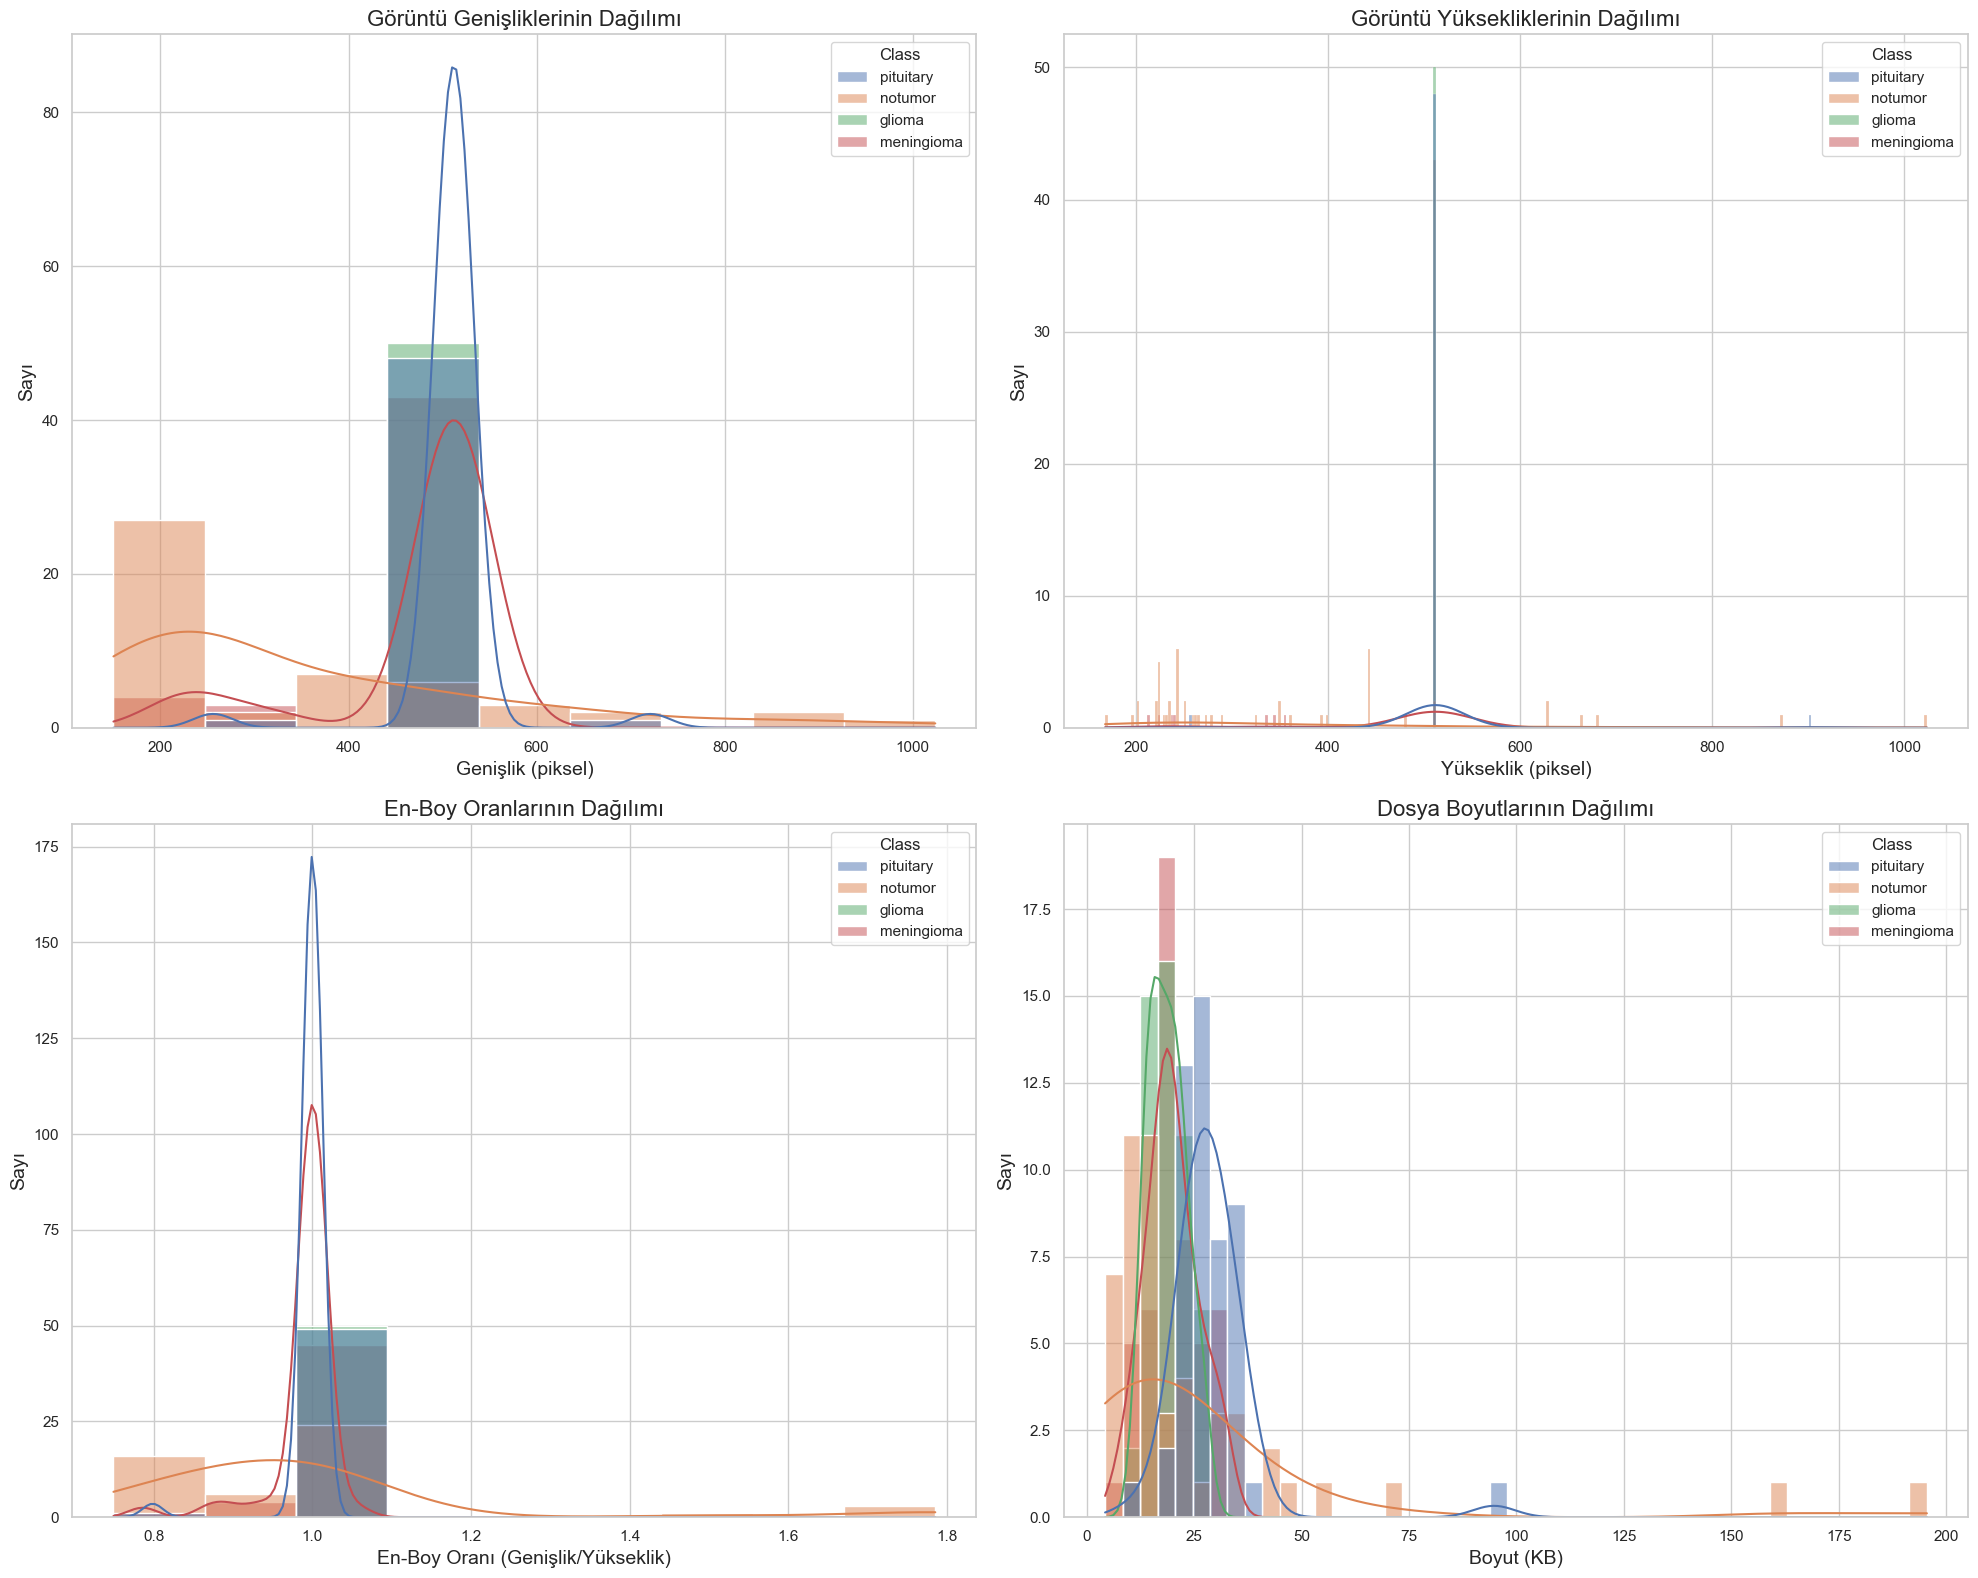

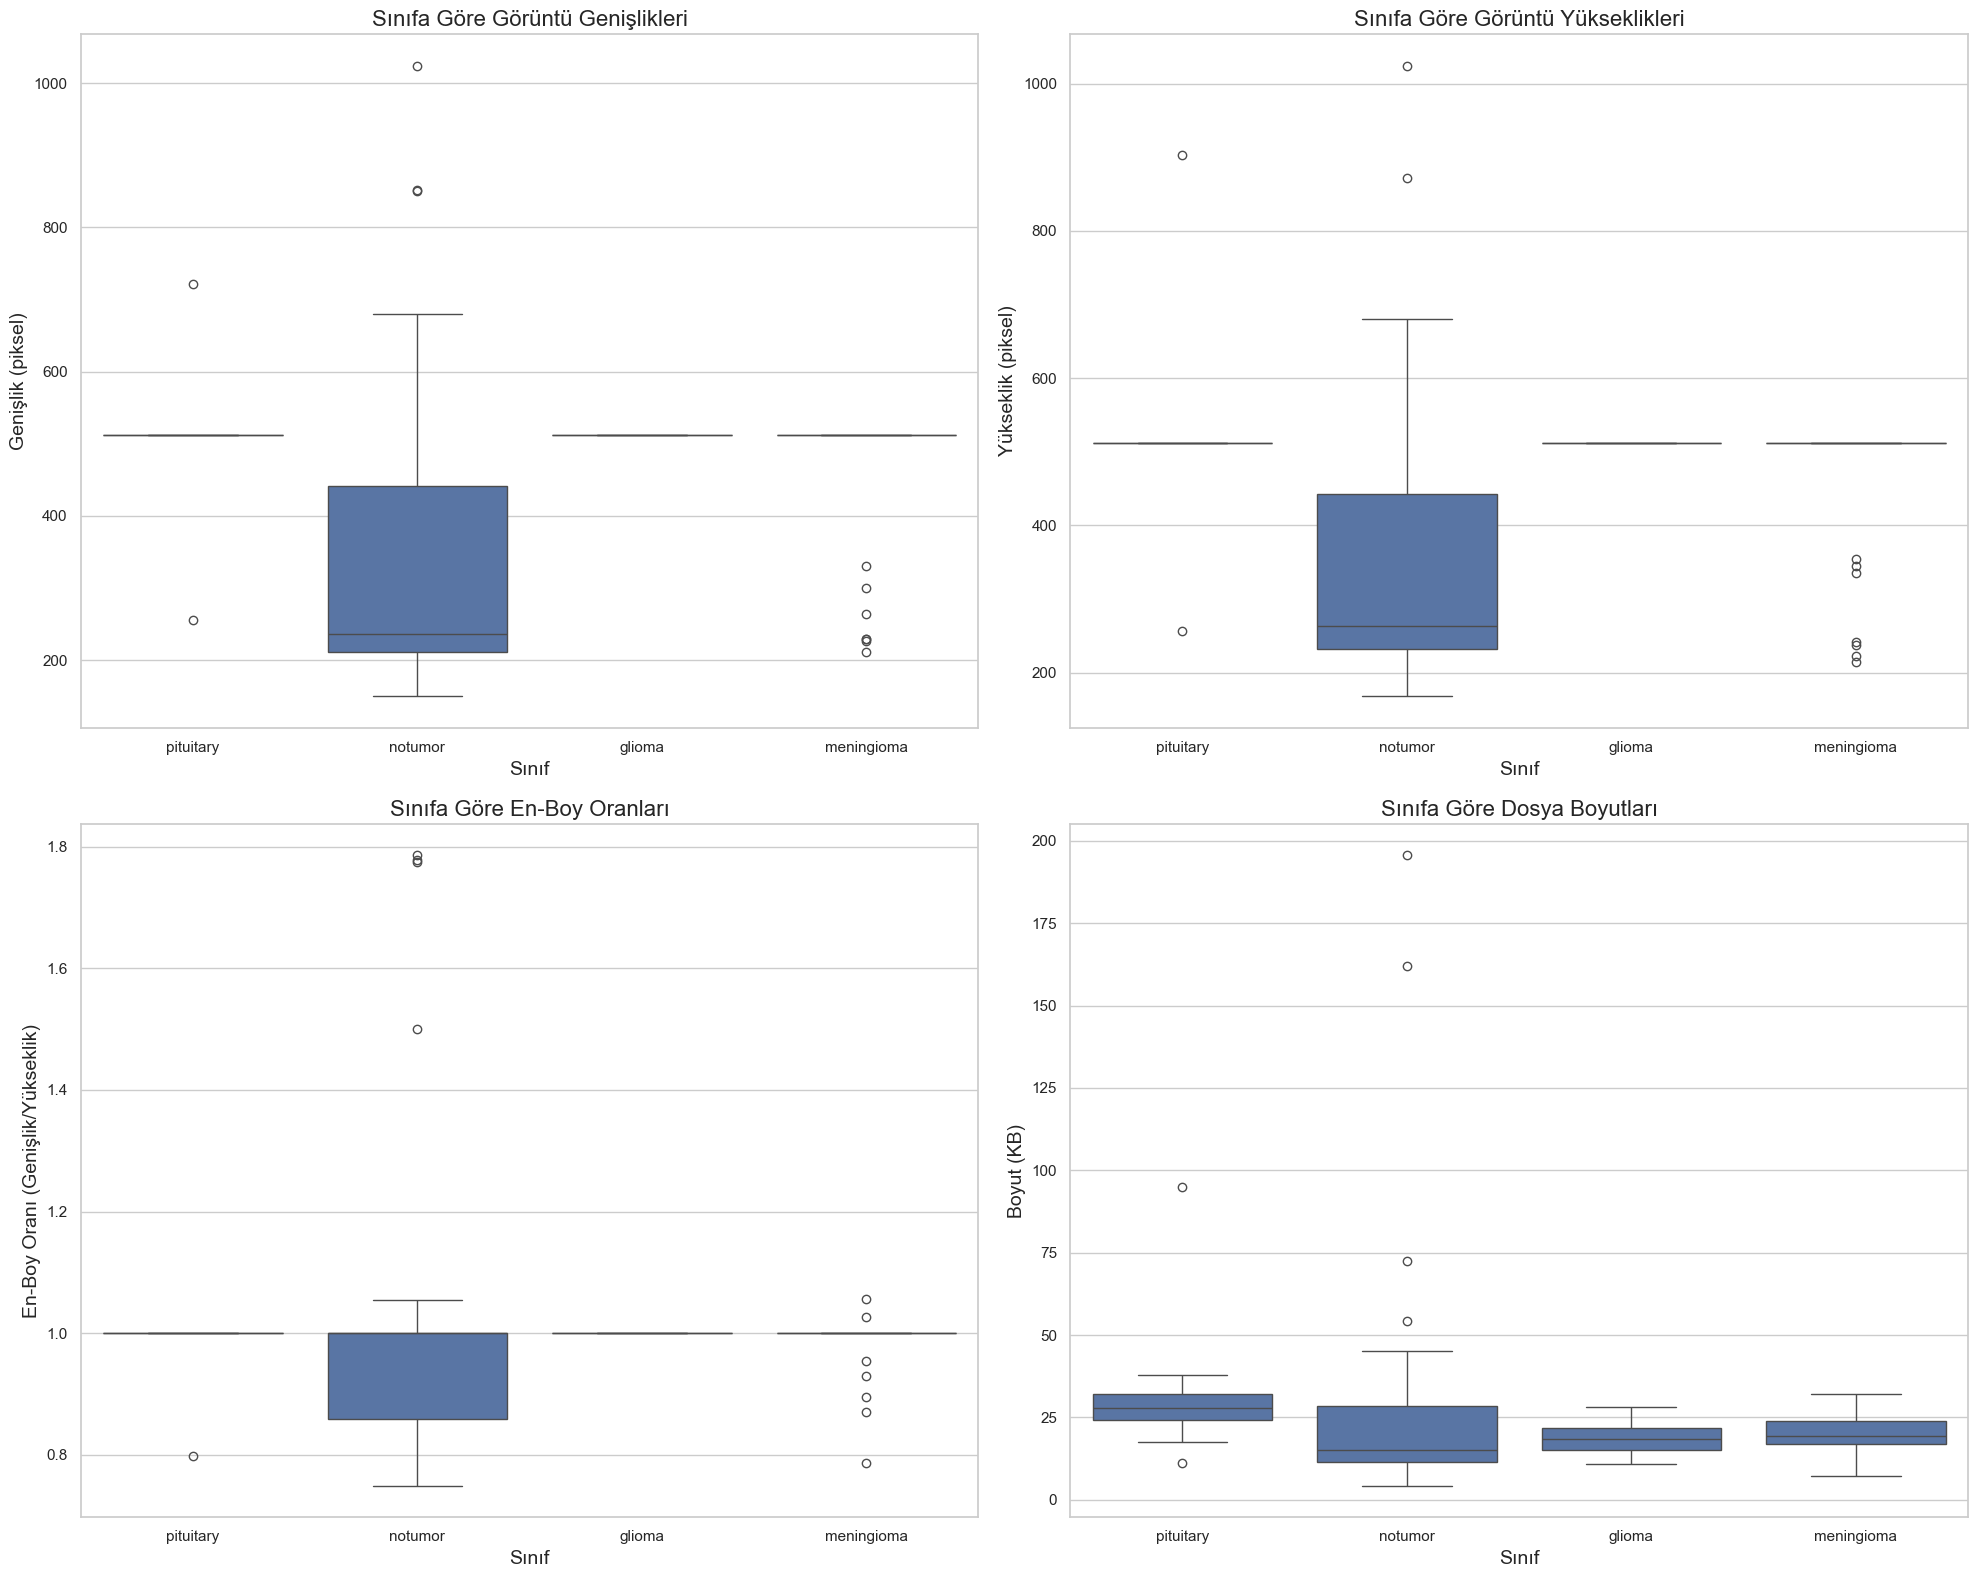

In [15]:
visualize_image_properties(image_props_df)



## Piksel Yoğunluğu Analizi


In [16]:
def analyze_pixel_intensities(data_dir, split='Training', num_samples=25):
    split_dir = data_dir / split
    class_dirs = sorted([d for d in split_dir.iterdir() if d.is_dir()])
    
    # Her sınıf için ortalama piksel yoğunluklarını saklamak için sözlük
    class_intensities = {}
    
    for class_dir in class_dirs:
        class_name = class_dir.name
        image_paths = list(class_dir.glob('*.jpg'))
        
        # Rastgele görüntü seçme
        selected_images = random.sample(image_paths, min(num_samples, len(image_paths)))
        
        # Bu sınıf için ortalama yoğunlukları saklamak için liste
        intensities = []
        
        for img_path in selected_images:
            # Görüntüyü gri tonlamalı olarak okuma
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            
            # Ortalama piksel yoğunluğunu hesaplama
            mean_intensity = np.mean(img)
            intensities.append(mean_intensity)
        
        class_intensities[class_name] = intensities
    
    # DataFrame oluşturma
    intensity_df = pd.DataFrame(class_intensities)
    
    # Ortalama piksel yoğunluklarının dağılımını çizme
    plt.figure(figsize=(14, 8))
    
    # Keman grafikleri oluşturma
    sns.violinplot(data=intensity_df, palette='viridis')
    
    plt.title('Sınıfa Göre Ortalama Piksel Yoğunluklarının Dağılımı', fontsize=16)
    plt.xlabel('Sınıf', fontsize=14)
    plt.ylabel('Ortalama Piksel Yoğunluğu', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()
    
    return intensity_df



Piksel yoğunluklarını analiz etme


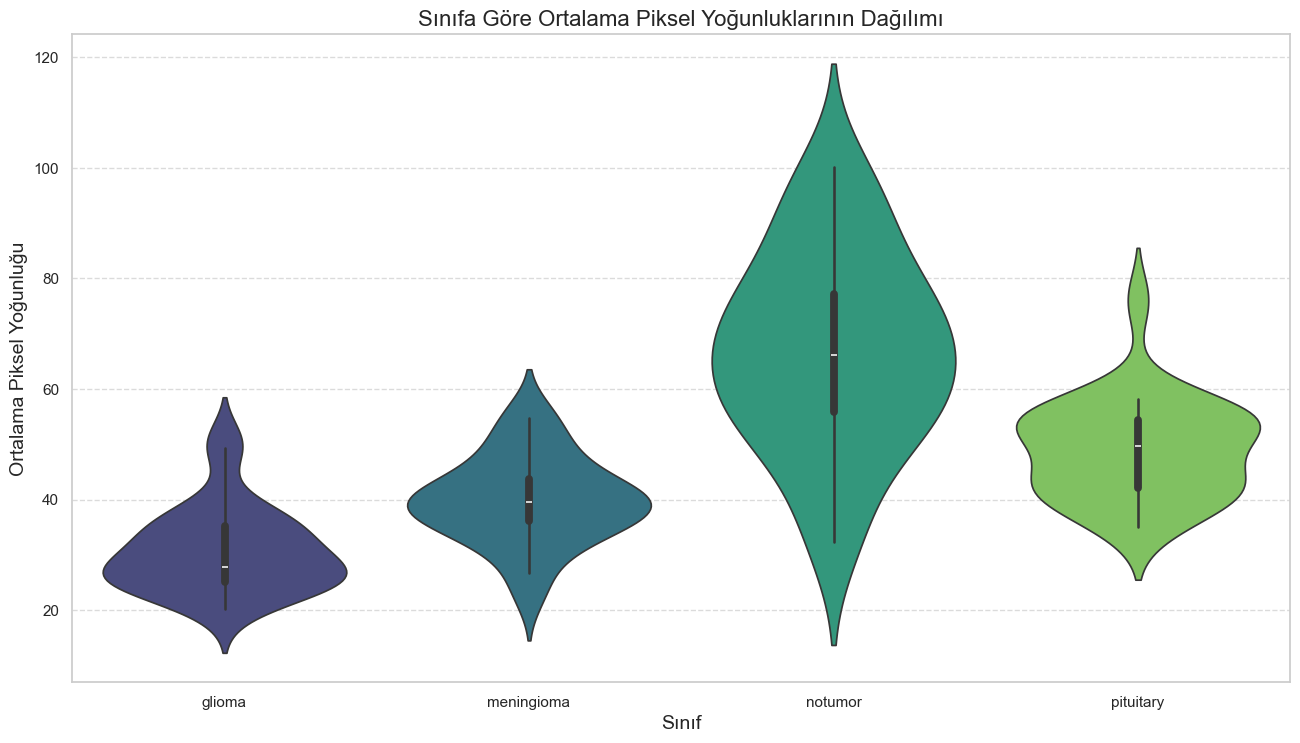

In [17]:
intensity_df = analyze_pixel_intensities(data_dir, split='Training', num_samples=25)



## Görüntü Ön İşleme Örneği


In [18]:
def preprocess_image(img_path, target_size=(224, 224)):
    # Görüntüyü okuma
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR'den RGB'ye dönüştürme
    
    # Görüntüyü yeniden boyutlandırma
    img_resized = cv2.resize(img, target_size)
    
    # Piksel değerlerini [0, 1] aralığına normalize etme
    img_normalized = img_resized / 255.0
    
    return img, img_resized, img_normalized

def show_preprocessing_steps(data_dir, split='Training'):
    split_dir = data_dir / split
    class_dirs = sorted([d for d in split_dir.iterdir() if d.is_dir()])
    
    # Rastgele bir sınıf seçme
    class_dir = random.choice(class_dirs)
    class_name = class_dir.name
    
    # Rastgele bir görüntü seçme
    img_path = random.choice(list(class_dir.glob('*.jpg')))
    
    # Görüntüyü ön işleme
    original, resized, normalized = preprocess_image(img_path)
    
    # Ön işleme adımlarını gösterme
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Orijinal görüntü
    axes[0].imshow(original)
    axes[0].set_title(f'Orijinal Görüntü\n{class_name}\nBoyut: {original.shape[1]}x{original.shape[0]}', fontsize=14)
    axes[0].axis('off')
    
    # Yeniden boyutlandırılmış görüntü
    axes[1].imshow(resized)
    axes[1].set_title(f'Yeniden Boyutlandırılmış Görüntü\nBoyut: {resized.shape[1]}x{resized.shape[0]}', fontsize=14)
    axes[1].axis('off')
    
    # Normalize edilmiş görüntü
    axes[2].imshow(normalized)
    axes[2].set_title('Normalize Edilmiş Görüntü\nPiksel Değerleri: [0, 1]', fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Görüntü Ön İşleme Adımları', fontsize=16, y=1.02)
    plt.show()



Ön işleme adımlarını gösterme


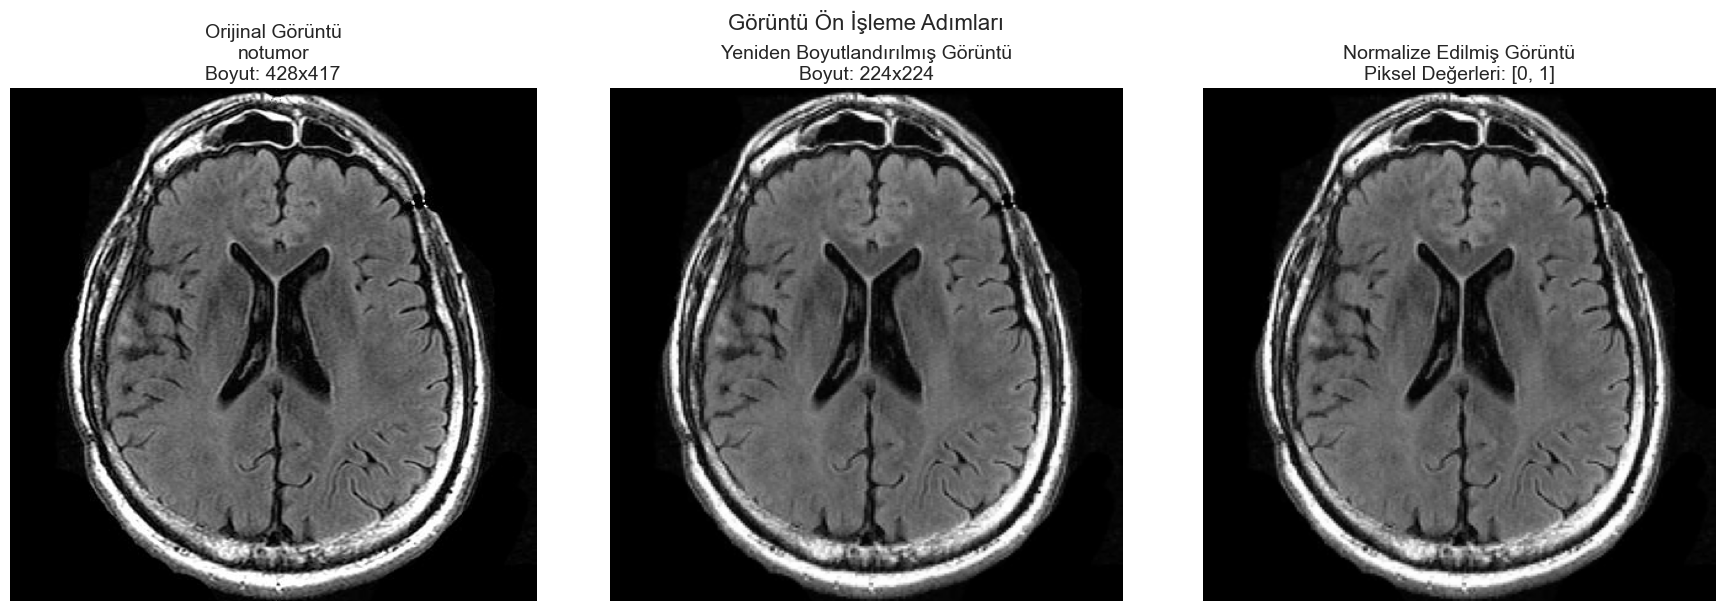

In [19]:
show_preprocessing_steps(data_dir, split='Training')



## Renk Histogramları Analizi


In [20]:
def analyze_color_histograms(data_dir, split='Training'):
    split_dir = data_dir / split
    class_dirs = sorted([d for d in split_dir.iterdir() if d.is_dir()])
    
    # Bir şekil oluşturma
    fig, axes = plt.subplots(len(class_dirs), 3, figsize=(18, 5*len(class_dirs)))
    
    for i, class_dir in enumerate(class_dirs):
        class_name = class_dir.name
        
        # Rastgele bir görüntü seçme
        img_path = random.choice(list(class_dir.glob('*.jpg')))
        
        # Görüntüyü okuma
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Görüntüyü gösterme
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'{class_name} Örneği', fontsize=14)
        axes[i, 0].axis('off')
        
        # Histogramları hesaplama
        color = ('r', 'g', 'b')
        for j, col in enumerate(color):
            hist = cv2.calcHist([img], [j], None, [256], [0, 256])
            axes[i, 1].plot(hist, color=col)
            axes[i, 1].set_xlim([0, 256])
        
        axes[i, 1].set_title('RGB Histogramı', fontsize=14)
        axes[i, 1].grid(alpha=0.3)
        
        # Gri tonlamalı histogram
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hist_gray = cv2.calcHist([img_gray], [0], None, [256], [0, 256])
        axes[i, 2].plot(hist_gray, color='k')
        axes[i, 2].set_xlim([0, 256])
        axes[i, 2].set_title('Gri Tonlamalı Histogram', fontsize=14)
        axes[i, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()



Renk histogramlarını analiz etme


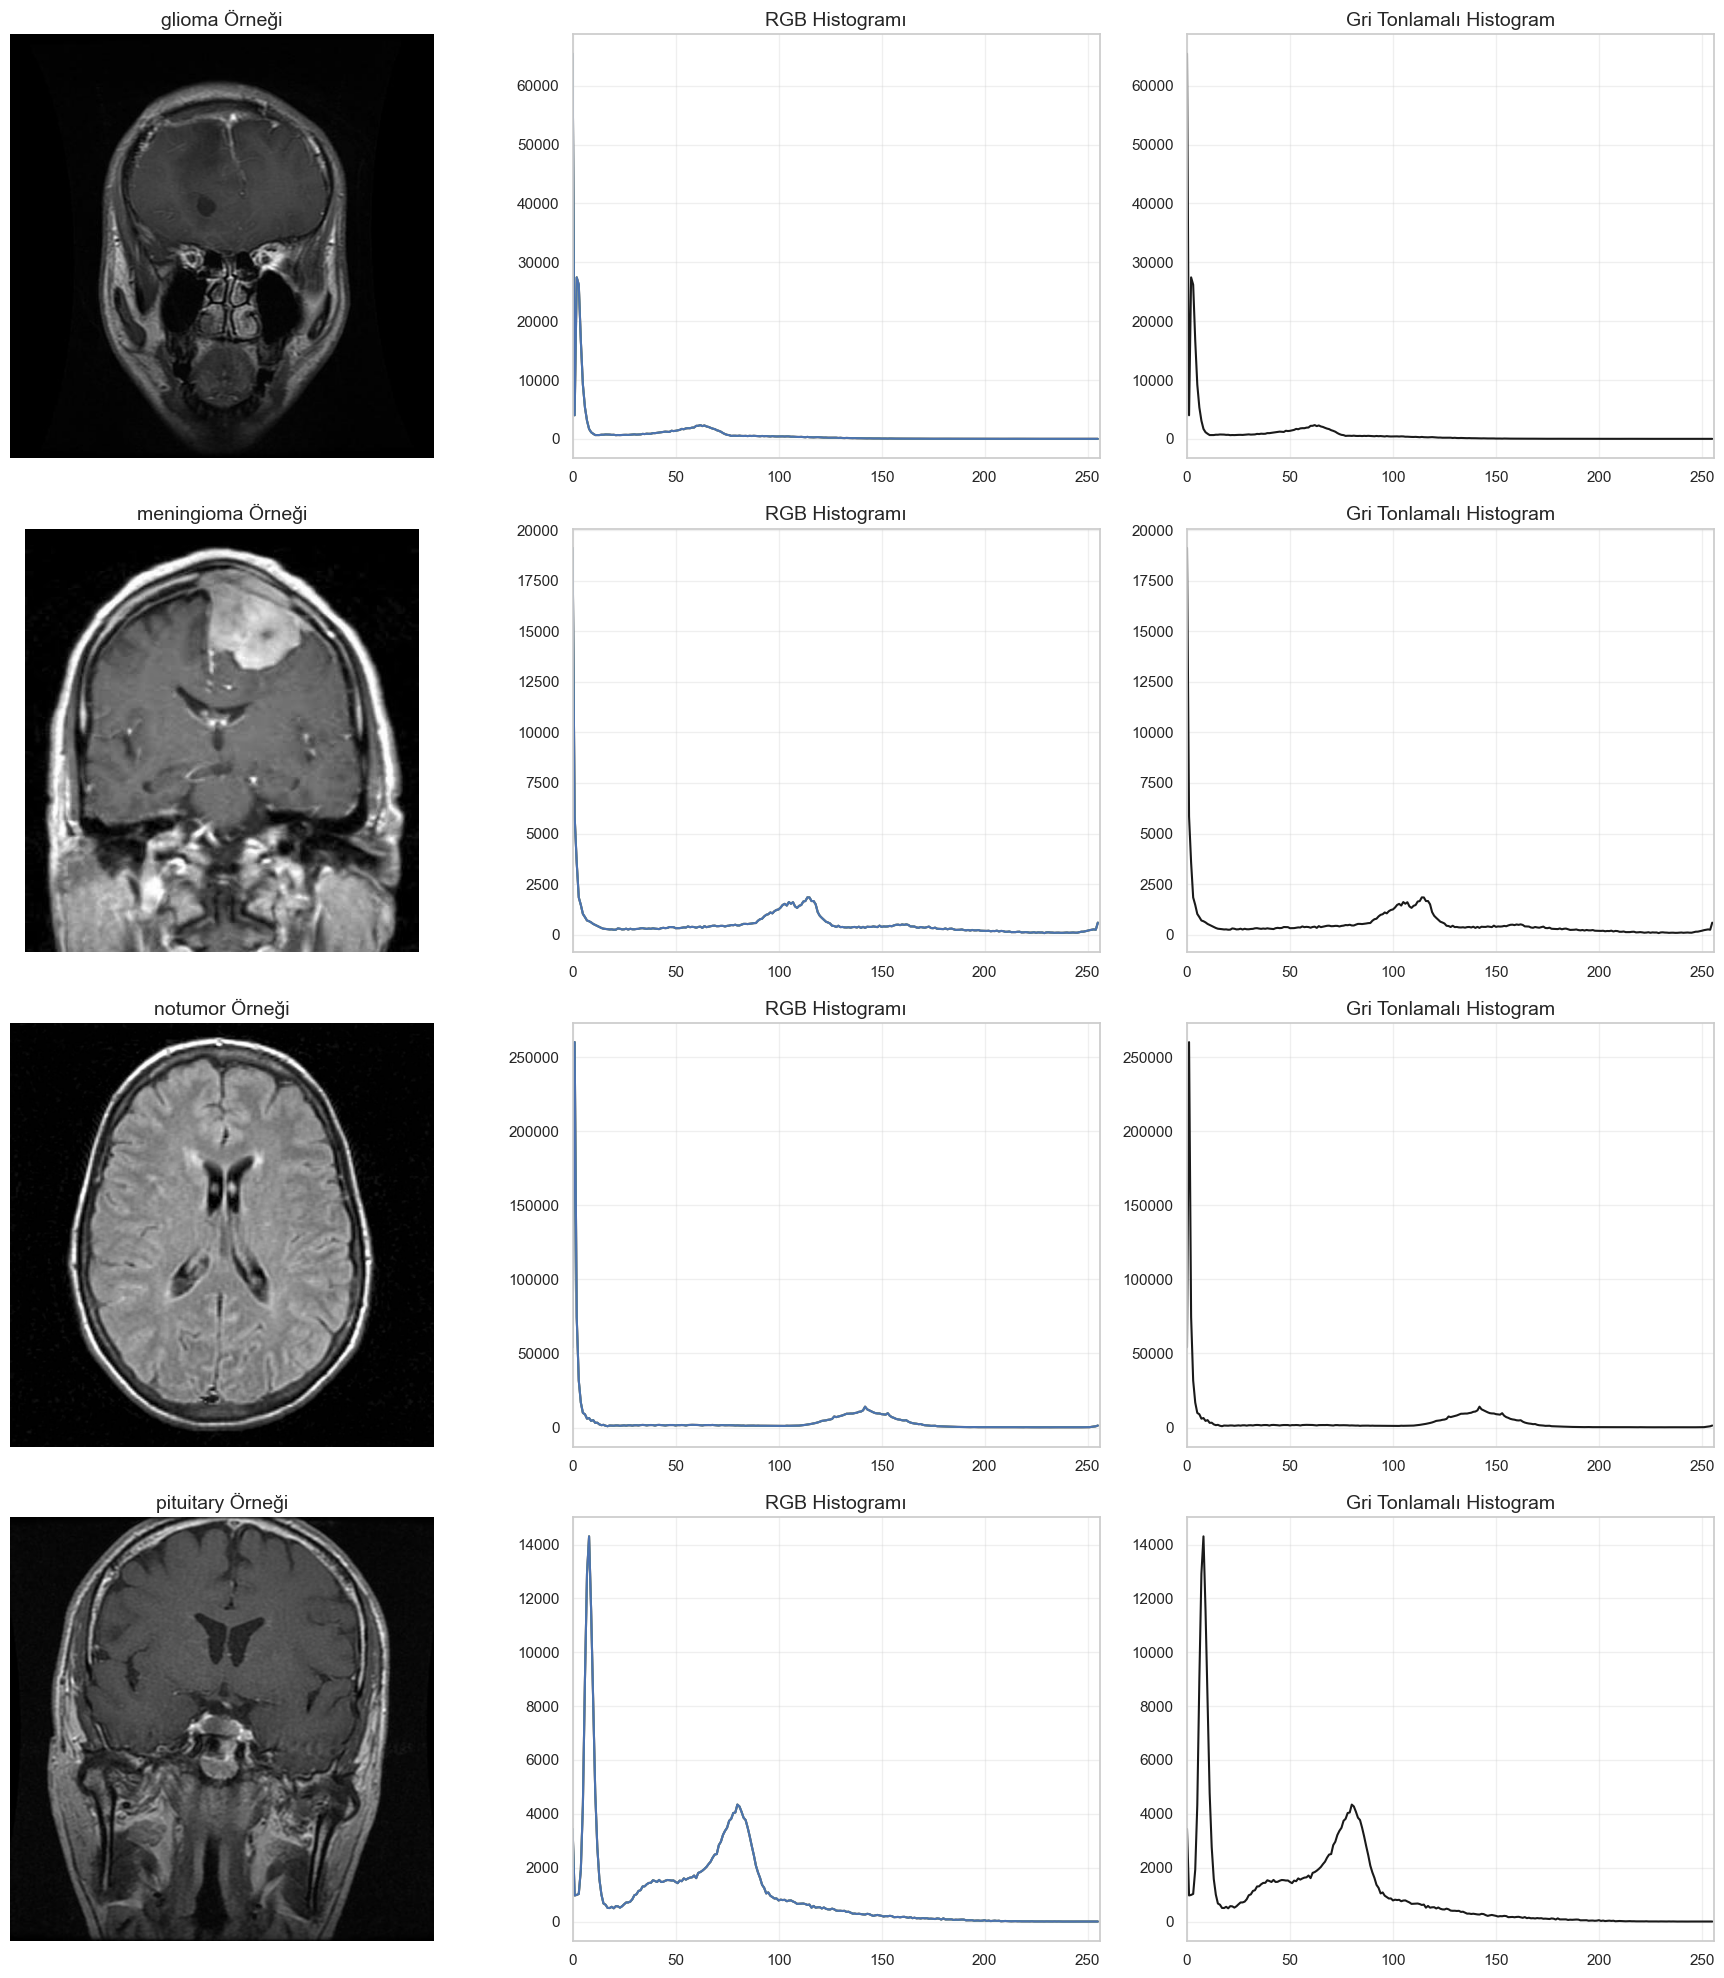

In [21]:
analyze_color_histograms(data_dir, split='Training')



## Veri Artırma Örnekleri


In [22]:
def show_data_augmentation_examples(data_dir, split='Training'):
    split_dir = data_dir / split
    class_dirs = sorted([d for d in split_dir.iterdir() if d.is_dir()])
    
    # Rastgele bir sınıf seçme
    class_dir = random.choice(class_dirs)
    class_name = class_dir.name
    
    # Rastgele bir görüntü seçme
    img_path = random.choice(list(class_dir.glob('*.jpg')))
    
    # Görüntüyü okuma ve yeniden boyutlandırma
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    
    # Veri artırma örnekleri
    # 1. Döndürme
    rows, cols = img.shape[:2]
    M1 = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1)
    img_rotated_15 = cv2.warpAffine(img, M1, (cols, rows))
    
    M2 = cv2.getRotationMatrix2D((cols/2, rows/2), -15, 1)
    img_rotated_neg15 = cv2.warpAffine(img, M2, (cols, rows))
    
    # 2. Yatay çevirme
    img_flipped_h = cv2.flip(img, 1)
    
    # 3. Dikey çevirme
    img_flipped_v = cv2.flip(img, 0)
    
    # 4. Parlaklık ayarlama
    img_bright = cv2.convertScaleAbs(img, alpha=1.2, beta=10)
    img_dark = cv2.convertScaleAbs(img, alpha=0.8, beta=-10)
    
    # 5. Zoom
    zoom_factor = 0.8
    zoomed_h, zoomed_w = int(rows * zoom_factor), int(cols * zoom_factor)
    y_offset = (rows - zoomed_h) // 2
    x_offset = (cols - zoomed_w) // 2
    
    img_zoomed = cv2.resize(img, (zoomed_w, zoomed_h))
    img_zoomed_padded = np.zeros_like(img)
    img_zoomed_padded[y_offset:y_offset+zoomed_h, x_offset:x_offset+zoomed_w] = img_zoomed
    
    # Veri artırma örneklerini gösterme
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Orijinal görüntü
    axes[0, 0].imshow(img)
    axes[0, 0].set_title(f'Orijinal Görüntü\n{class_name}', fontsize=14)
    axes[0, 0].axis('off')
    
    # Döndürülmüş görüntüler
    axes[0, 1].imshow(img_rotated_15)
    axes[0, 1].set_title('Döndürme (+15 derece)', fontsize=14)
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(img_rotated_neg15)
    axes[0, 2].set_title('Döndürme (-15 derece)', fontsize=14)
    axes[0, 2].axis('off')
    
    # Yatay çevrilmiş görüntü
    axes[0, 3].imshow(img_flipped_h)
    axes[0, 3].set_title('Yatay Çevirme', fontsize=14)
    axes[0, 3].axis('off')
    
    # Dikey çevrilmiş görüntü
    axes[1, 0].imshow(img_flipped_v)
    axes[1, 0].set_title('Dikey Çevirme', fontsize=14)
    axes[1, 0].axis('off')
    
    # Parlaklık ayarlanmış görüntüler
    axes[1, 1].imshow(img_bright)
    axes[1, 1].set_title('Parlaklık Artırma', fontsize=14)
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(img_dark)
    axes[1, 2].set_title('Parlaklık Azaltma', fontsize=14)
    axes[1, 2].axis('off')
    
    # Zoom yapılmış görüntü
    axes[1, 3].imshow(img_zoomed_padded)
    axes[1, 3].set_title('Zoom', fontsize=14)
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Veri Artırma Örnekleri', fontsize=16, y=1.02)
    plt.show()



Veri artırma örneklerini gösterme


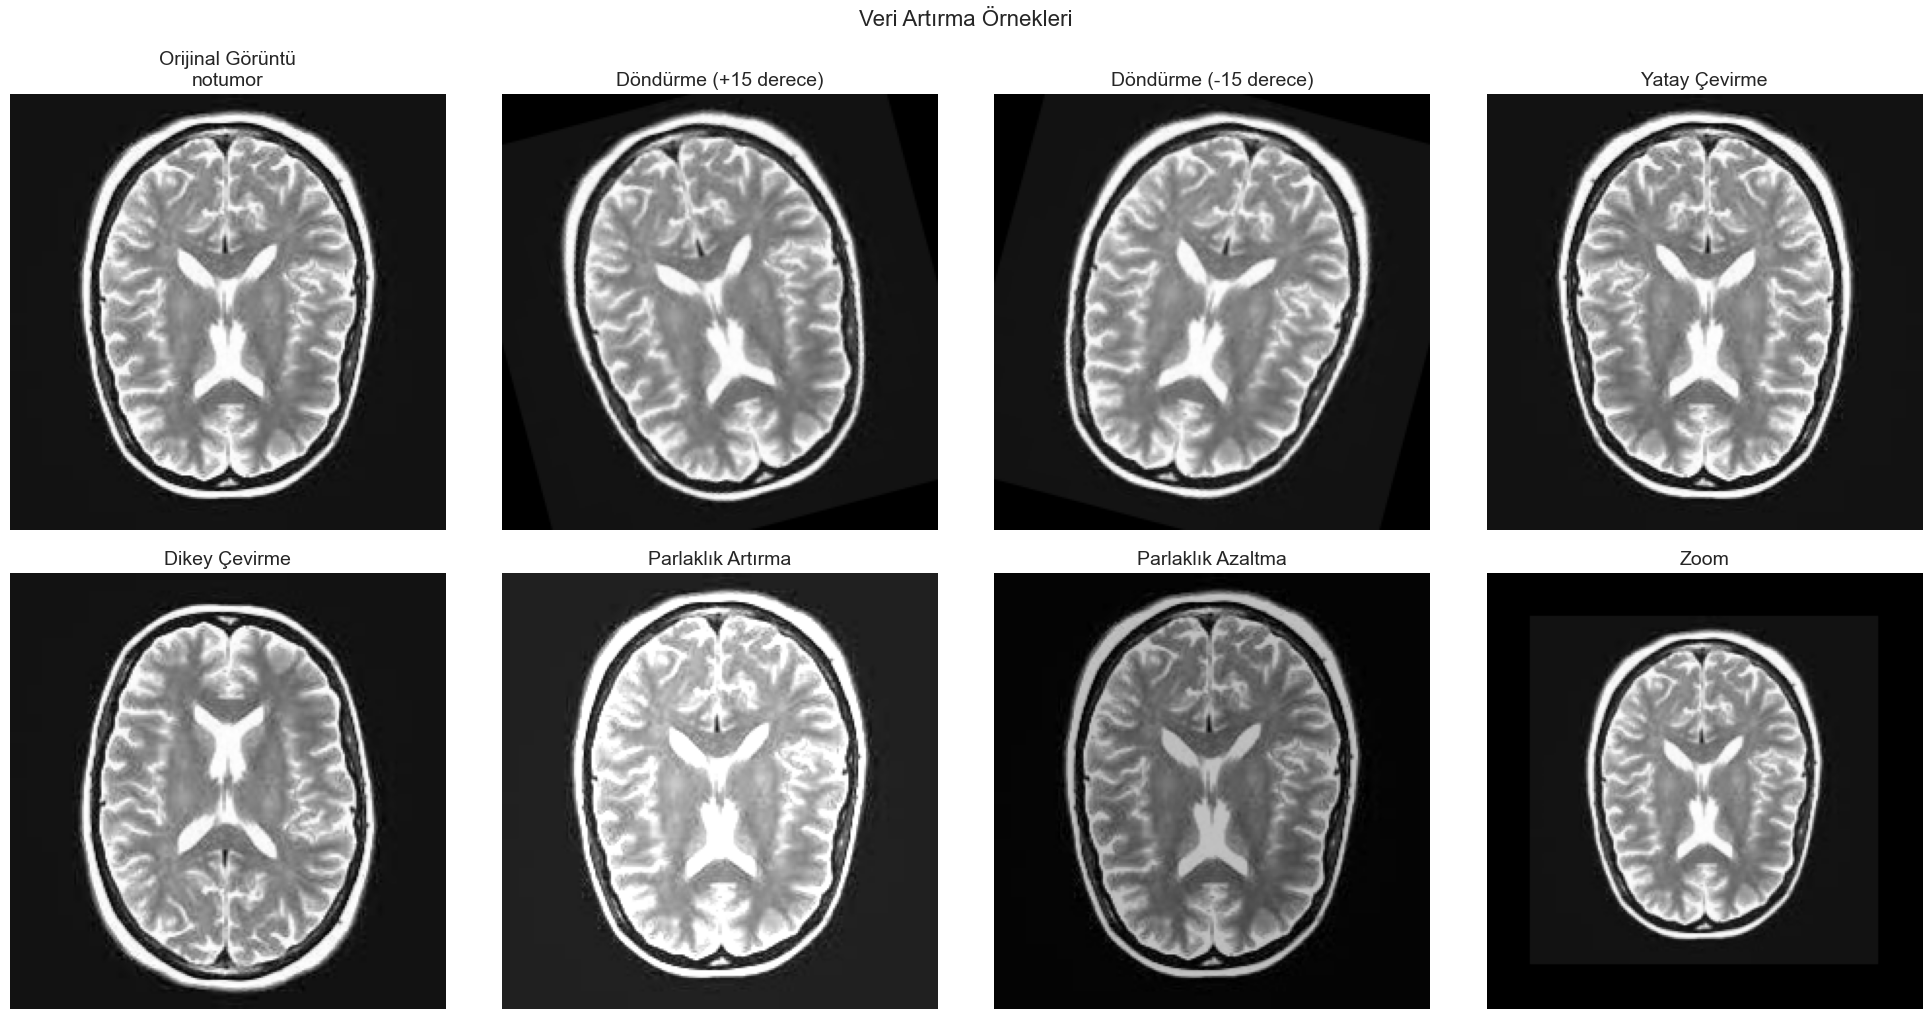

In [23]:
show_data_augmentation_examples(data_dir, split='Training')



## Analiz Sonuçları


Veri seti analizi sonucunda aşağıdaki bulgular elde edilmiştir:


1. **Veri Seti Yapısı**:


   - Veri seti Eğitim ve Test setlerine ayrılmıştır


   - Dört sınıf vardır: glioma, meningioma, no tumor ve pituitary


   - Toplam 7023 görüntü bulunmaktadır (Eğitim: 5712, Test: 1311)


2. **Sınıf Dağılımı**:


   - Eğitim seti:


     - glioma: 1321 görüntü


     - meningioma: 1339 görüntü


     - no tumor: 1595 görüntü


     - pituitary: 1457 görüntü


   - Test seti:


     - glioma: 300 görüntü


     - meningioma: 306 görüntü


     - no tumor: 405 görüntü


     - pituitary: 300 görüntü


3. **Görüntü Özellikleri**:


   - Görüntüler farklı boyutlara sahiptir (72 farklı boyut)


   - Genişlik aralığı: 150-1024 piksel


   - Yükseklik aralığı: 168-1075 piksel


   - Ortalama en-boy oranı yaklaşık 1.0'dır (çoğunlukla kare şeklinde)


4. **Piksel Yoğunluğu Analizi**:


   - Sınıflar arasında piksel yoğunluğu dağılımlarında farklılıklar bulunmaktadır


   - Bu farklılıklar, model eğitimi için faydalı özellikler sağlayabilir


5. **Ön İşleme Önerileri**:


   - Analiz sonuçlarına dayanarak, aşağıdaki ön işleme adımları önerilmektedir:


     - Tüm görüntüleri standart bir boyuta (örn. 224x224) yeniden boyutlandırma


     - Piksel değerlerini [0, 1] aralığına normalize etme


     - Veri çeşitliliğini artırmak için veri artırma teknikleri uygulama


     - Döndürme, çevirme, yakınlaştırma gibi veri artırma teknikleri kullanma


6. **Sonraki Adımlar**:


   - CNN modeli geliştirme


   - Veri artırma uygulama


   - Model performansını test setinde değerlendirme


   - Yeni MR görüntülerini analiz edebilen ve tanı bilgisi sağlayan bir uygulama oluşturma
